In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from fastai import *
from fastai.vision import *
from pathlib import Path
import os

In [3]:
path_chexpert = Path('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/mimic-cxr-2.0.0-chexpert.csv.gz')
path_negbio = Path('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/mimic-cxr-2.0.0-negbio.csv.gz')
path_metadata = Path('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/mimic-cxr-2.0.0-metadata.csv.gz')

df_chexpert = pd.read_csv(path_chexpert)
df_negbio = pd.read_csv(path_negbio)
df_metadata = pd.read_csv(path_metadata)

In [4]:
# Adapted from https://github.com/MIT-LCP/mimic-cxr
df = df_negbio.merge(
    df_chexpert,
    how='left',
    left_on=['subject_id','study_id'], right_on=['subject_id','study_id'],
    suffixes=('', '_cx')
)

df_metadata.drop([
    'PerformedProcedureStepDescription', 
    'Rows', 
    'Columns', 
    'StudyDate', 
    'StudyTime', 
    'ProcedureCodeSequence_CodeMeaning', 
    'ViewCodeSequence_CodeMeaning', 
    'PatientOrientationCodeSequence_CodeMeaning'
],axis=1, inplace=True)

df = df_metadata.merge(
    df,
    how='left',
    left_on=['subject_id','study_id'], right_on=['subject_id','study_id'],
)
df.head()

,dicom_id,subject_id,study_id,ViewPosition,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,...,Enlarged Cardiomediastinum_cx,Fracture_cx,Lung Lesion_cx,Lung Opacity_cx,No Finding_cx,Pleural Effusion_cx,Pleural Other_cx,Pneumonia_cx,Pneumothorax_cx,Support Devices_cx
0,02aa804e-bde0afdd-112c0b34-7bc16630-4e384014,10000032,50414267,PA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
1,174413ec-4ec4c1f7-34ea26b7-c5f994f8-79ef1962,10000032,50414267,LATERAL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
2,2a2277a9-b0ded155-c0de8eb9-c124d10e-82c5caab,10000032,53189527,PA,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
3,e084de3b-be89b11e-20fe3f9f-9c8d8dfe-4cfd202c,10000032,53189527,LATERAL,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,AP,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN


In [5]:
# Preprocess data:
# Only use data that is a '1.0'
# Remove all disagreeing '1.0' data
# Remove all Pleural Other findings
# Remove all non antero-posterior (AP) data
# Original Length was 377110, New Length: 134017
for key in df.columns:
    if key in ('dicom_id','subject_id','study_id', 'ViewPosition'):
        continue
    
    if key[-3:] == '_cx':
        continue
        
    # Remove data that is not a '1.0'
    df[key] = df[key].map({1:key})
    df[key + '_cx'] = df[key + '_cx'].map({1:key})
    
    # Remove all disagreeing '1.0' data
    agree_matrix = df[key].fillna(0) == df[key + '_cx'].fillna(0)
    df = df[agree_matrix]

# Remove all Pleural Other Data
keep = df['Pleural Other'].map({'Pleural Other': False}).fillna(True)
df = df[keep]

# Remove all non antero-posterior (AP) data
keep = df['ViewPosition'].map({'AP': True}).fillna(False)
df = df[keep]

# Remove Columns
df.drop([key for key in df.columns if key[-3:] == '_cx'], axis=1, inplace=True)
df.drop(['ViewPosition','Pleural Other'], axis=1, inplace=True)
df.head()


,dicom_id,subject_id,study_id,Atelectasis,Cardiomegaly,Consolidation,Edema,Enlarged Cardiomediastinum,Fracture,Lung Lesion,Lung Opacity,No Finding,Pleural Effusion,Pneumonia,Pneumothorax,Support Devices
4,68b5c4b1-227d0485-9cc38c3f-7b84ab51-4b472714,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Finding,NaN,NaN,NaN,NaN
5,fffabebf-74fd3a1f-673b6b41-96ec0ac9-2ab69818,10000032,53911762,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Finding,NaN,NaN,NaN,NaN
6,ea030e7a-2e3b1346-bc518786-7a8fd698-f673b44c,10000032,56699142,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No Finding,NaN,NaN,NaN,NaN
7,096052b7-d256dc40-453a102b-fa7d01c6-1b22c6b4,10000764,57375967,NaN,NaN,Consolidation,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
15,d0b71acc-b5a62046-bbb5f6b8-7b173b85-65cdf738,10000935,50578979,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Pleural Effusion,Pneumonia,NaN,NaN


In [6]:
test_df = df.head(100).copy()
test_df['file_path'] = test_df[[key for key in df.columns if key in ('dicom_id', 'subject_id', 'study_id')]].apply(lambda x: f"p{str(x.values[1])[:2]}/p{x.values[1]}/s{x.values[2]}/{x.values[0]}.jpg", axis=1)
combine_column = [key for key in df.columns if key not in ('dicom_id', 'subject_id', 'study_id')]
test_df['labels'] = test_df[combine_column].apply(lambda x: ','.join(x.dropna().values.tolist()), axis=1)
test_df.drop(df.columns, axis=1, inplace=True)
# Remove all data that does not have a label
test_df = test_df[~(test_df['labels']=='')]
test_df

,file_path,labels
4,p10/p10000032/s53911762/68b5c4b1-227d0485-9cc3...,No Finding
5,p10/p10000032/s53911762/fffabebf-74fd3a1f-673b...,No Finding
6,p10/p10000032/s56699142/ea030e7a-2e3b1346-bc51...,No Finding
7,p10/p10000764/s57375967/096052b7-d256dc40-453a...,Consolidation
15,p10/p10000935/s50578979/d0b71acc-b5a62046-bbb5...,"Pleural Effusion,Pneumonia"
...,...,...
292,p10/p10003637/s51371378/6aeadf6d-56fb29f1-8135...,Cardiomegaly
293,p10/p10003637/s51461467/519a3958-182826e9-f754...,No Finding
298,p10/p10004235/s52379321/3813b9b6-88d998b4-941e...,"Atelectasis,Enlarged Cardiomediastinum,Support..."
299,p10/p10004235/s52604377/5b05c3da-4f8f9c06-7b8c...,"No Finding,Support Devices"


In [7]:
path_img = Path('../../../../scratch/rl80/mimic-cxr-jpg-2.0.0.physionet.org/files/')
data = (ImageList.from_df(test_df, path_img)
        .split_by_rand_pct(0.2)
        .label_from_df(label_delim=',')
        .transform('', size=224)
        .databunch(bs=16))

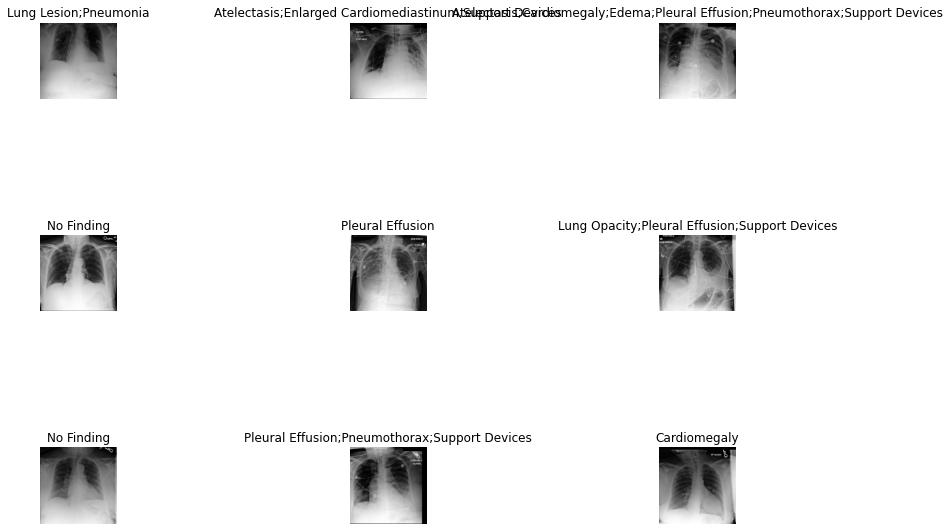

In [8]:
data.show_batch(rows=3, figsize=(12,9))